In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from nltk.corpus import stopwords
import json
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [45]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.utils.pad_sequences
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Embedding = tf.keras.layers.Embedding
LSTM = tf.keras.layers.LSTM
SpatialDropout1D = tf.keras.layers.SpatialDropout1D
EarlyStopping = tf.keras.callbacks.EarlyStopping
to_categorical = tf.keras.utils.to_categorical
Dropout = tf.keras.layers.Dropout

In [46]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_experimental',
    config={"model_name": "LSTM"}
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [47]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [48]:
config = wandb.config

config.maxlen = 320
config.vocab_size = 20000
config.embedding_dims = 100
config.epochs = 7
config.hidden_dims = 100
config.batch_size = 32

In [50]:
df = pd.read_csv('../datasets/quotes/quotes_step3.csv')

print("===================== DATASET VALUES =============================")
print(df["cefr1"].value_counts())
print(df["cefr2"].value_counts())
print(df["cefr3"].value_counts())
print(df["cefr4"].value_counts())
print(df["cefr5"].value_counts())
print(df["cefr6"].value_counts())
print(df["cefr7"].value_counts())
print("===================== DATASET VALUES =============================")
df_a1 = df[df['cefr7'] == 'A1'].sample(6761, random_state=42)
df_a2 = df[df['cefr7'] == 'A2'].sample(5797, random_state=42)
df_b1 = df[df['cefr7'] == 'B1'].sample(1641, random_state=42)
df_b2 = df[df['cefr7'] == 'B2'].sample(2709, random_state=42)
df_c1 = df[df['cefr7'] == 'C1'].sample(2373, random_state=42)
df_c2 = df[df['cefr7'] == 'C2'].sample(719, random_state=42)

combined_df = pd.concat([df_a1, df_a2, df_b1, df_b2, df_c1, df_c2]).reset_index(drop=True)

train_df_a1 = combined_df[combined_df['cefr7'] == 'A1'].sample(5362, random_state=42)
combined_df = combined_df.drop(train_df_a1.index)
train_df_a2 = combined_df[combined_df['cefr7'] == 'A2'].sample(4666, random_state=42)
combined_df = combined_df.drop(train_df_a2.index)
train_df_b1 = combined_df[combined_df['cefr7'] == 'B1'].sample(1304, random_state=42)
combined_df = combined_df.drop(train_df_b1.index)
train_df_b2 = combined_df[combined_df['cefr7'] == 'B2'].sample(2159, random_state=42)
combined_df = combined_df.drop(train_df_b2.index)
train_df_c1 = combined_df[combined_df['cefr7'] == 'C1'].sample(1937, random_state=42)
combined_df = combined_df.drop(train_df_c1.index)
train_df_c2 = combined_df[combined_df['cefr7'] == 'C2'].sample(572, random_state=42)
combined_df = combined_df.drop(train_df_c2.index)

train = pd.concat([train_df_a1, train_df_a2, train_df_b1, train_df_b2, train_df_c1, train_df_c2])

test_df_a1 = combined_df[combined_df['cefr7'] == 'A1'].sample(695, random_state=42)
combined_df = combined_df.drop(test_df_a1.index)
test_df_a2 = combined_df[combined_df['cefr7'] == 'A2'].sample(581, random_state=42)
combined_df = combined_df.drop(test_df_a2.index)
test_df_b1 = combined_df[combined_df['cefr7'] == 'B1'].sample(159, random_state=42)
combined_df = combined_df.drop(test_df_b1.index)
test_df_b2 = combined_df[combined_df['cefr7'] == 'B2'].sample(275, random_state=42)
combined_df = combined_df.drop(test_df_b2.index)
test_df_c1 = combined_df[combined_df['cefr7'] == 'C1'].sample(224, random_state=42)
combined_df = combined_df.drop(test_df_c1.index)
test_df_c2 = combined_df[combined_df['cefr7'] == 'C2'].sample(66, random_state=42)
combined_df = combined_df.drop(test_df_c2.index)

test = pd.concat([test_df_a1, test_df_a2, test_df_b1, test_df_b2, test_df_c1, test_df_c2])

validation = combined_df.sample(frac=1)

train['level'] = train['cefr7']
validation['level'] = validation['cefr7']
test['level'] = test['cefr7']

train['label'] = train['level'].apply(lambda x: label_to_id_mapping[x])
test['label'] = test['level'].apply(lambda x: label_to_id_mapping[x])
validation['label'] = validation['level'].apply(lambda x: label_to_id_mapping[x])

print(train['level'].value_counts())
print(test['level'].value_counts())
print(validation['level'].value_counts())

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

test = pd.concat([test,validation], ignore_index=True)

===================== DATASET VALUES =============================
cefr1
A2    153080
A1     44811
B1     20822
B2       109
Name: count, dtype: int64
cefr2
A1    128412
A2     90226
B1       184
Name: count, dtype: int64
cefr3
A1    128412
A2     90226
B1       184
Name: count, dtype: int64
cefr4
A2    153446
A1     62836
B1      2537
B2         3
Name: count, dtype: int64
cefr5
A2    111743
B1     72503
A1     20906
B2     12665
C1       963
C2        42
Name: count, dtype: int64
cefr6
A2    153306
A1     50433
B1     14949
B2       134
Name: count, dtype: int64
cefr7
B2    64432
B1    50758
C1    49438
A2    31773
C2    11668
A1    10753
Name: count, dtype: int64
===================== DATASET VALUES =============================
level
A1    5362
A2    4666
B2    2159
C1    1937
B1    1304
C2     572
Name: count, dtype: int64
level
A1    695
A2    581
B2    275
C1    224
B1    159
C2     66
Name: count, dtype: int64
level
A1    704
A2    550
B2    275
C1    212
B1    178
C2     81
Na

In [51]:
def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)  
    text = text.replace('x', '')
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [52]:
train['cleaned_text'] = train['text'].apply(clean_text)
test['cleaned_text'] = test['text'].apply(clean_text)
validation['cleaned_text'] = validation['text'].apply(clean_text)

train['cleaned_text'] = train['cleaned_text'].str.replace('\d+', '')
test['cleaned_text'] = test['cleaned_text'].str.replace('\d+', '')
validation['cleaned_text'] = validation['cleaned_text'].str.replace('\d+', '')

In [53]:
tokenizer = Tokenizer(num_words=config.vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts( pd.concat([train['cleaned_text'], test['cleaned_text'], validation['cleaned_text']], ignore_index=True).values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 25453 unique tokens.


In [54]:
X_train_raw = train['cleaned_text']
Y_train_raw = train['label']
X_test_raw = test['cleaned_text']
Y_test_raw = test['label']

X_train = tokenizer.texts_to_sequences(X_train_raw.values)
X_train = pad_sequences(X_train, maxlen=config.maxlen)

Y_train = pd.get_dummies(Y_train_raw).values


X_test = tokenizer.texts_to_sequences(X_test_raw.values)
X_test = pad_sequences(X_test, maxlen=config.maxlen)

Y_test = pd.get_dummies(Y_test_raw).values

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16000, 320) (16000, 6)
(4000, 320) (4000, 6)


In [55]:
model = Sequential()
model.add(Embedding(config.vocab_size, config.embedding_dims))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(config.hidden_dims, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
class WandbClfEvalCallback(WandbEvalCallback):
    def __init__(self, validation_data, data_table_columns, pred_table_columns):
        super().__init__(data_table_columns, pred_table_columns)

        self.x = validation_data[0]
        self.y = validation_data[1]

    def add_ground_truth(self, logs=None):
        for idx, (text, label) in enumerate(zip(self.x, self.y)):
            self.data_table.add_data(idx, text, label)

    def add_model_predictions(self, epoch, logs=None):
        preds = self.model.predict(self.x, verbose=0)
        preds = tf.argmax(preds, axis=-1)

        data_table_ref = self.data_table_ref
        table_idxs = data_table_ref.get_index()

        for idx in table_idxs:
            pred = preds[idx]
            self.pred_table.add_data(
                epoch,
                data_table_ref.data[idx][0],
                data_table_ref.data[idx][1],
                data_table_ref.data[idx][2],
                pred,
            )

history = model.fit(
    X_train,Y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), WandbMetricsLogger(),
               WandbClfEvalCallback(
                   validation_data=(X_train, Y_train),
                   data_table_columns=["idx", "text", "label"],
                   pred_table_columns=["epoch", "idx", "text", "label", "pred"],
               )]
)

wandb:   1 of 1 files downloaded.  


Epoch 1/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - accuracy: 0.3898 - loss: 1.4860 - val_accuracy: 0.5253 - val_loss: 1.1659
Epoch 2/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 62s 154ms/step - accuracy: 0.6008 - loss: 0.9918 - val_accuracy: 0.5769 - val_loss: 1.0524
Epoch 3/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 50s 126ms/step - accuracy: 0.7352 - loss: 0.7028 - val_accuracy: 0.6153 - val_loss: 0.9911
Epoch 4/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.8152 - loss: 0.5041 - val_accuracy: 0.6022 - val_loss: 1.1126
Epoch 5/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 56s 139ms/step - accuracy: 0.8865 - loss: 0.3314 - val_accuracy: 0.6056 - val_loss: 1.1920
Epoch 6/7
400/400 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - accuracy: 0.9301 - loss: 0.2227 - val_accuracy: 0.6159 - val_loss: 1.3402


In [38]:
accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5800 - loss: 1.2950
Test set
  Loss: 1.292
  Accuracy: 0.583


In [39]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
wandb.log({"Loss": plt})

C:\Users\kawis\anaconda3\Lib\site-packages\plotly\matplotlylib\renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [40]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
wandb.log({"Accuracy": plt})

In [41]:
import datetime 

def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    for index, row in p_test.iterrows():
        sentence = row['cleaned_text']
        pred_sentence = tokenizer.texts_to_sequences([sentence])
        pred_sentence = pad_sequences(pred_sentence, maxlen=config.maxlen)
        pred = model.predict(pred_sentence)
        p_test.loc[index, 'predictions'] = cefr_levels[np.argmax(pred)]


make_predictions(model, test)
print(f'Ended prediction at {datetime.datetime.now()}')

Started prediction at 2024-08-18 00:11:12.417842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Accuracy: 0.583
Accuracy for label A1: 0.756
Accuracy for label A2: 0.639
Accuracy for label B1: 0.303
Accuracy for label B2: 0.413
Accuracy for label C1: 0.479
Accuracy for label C2: 0.088

Classification Report:
              precision    recall  f1-score   support

          A1       0.79      0.76      0.77      1399
          A2       0.55      0.64      0.59      1131
          B1       0.24      0.30      0.27       337
          B2       0.47      0.41      0.44       550
          C1       0.50      0.48      0.49       436
          C2       0.62      0.09      0.15       147

    accuracy                           0.58      4000
   macro avg       0.53      0.45      0.45      4000
weighted avg       0.59      0.58      0.58      4000


Confusion Matrix:
[[1057  315   16    7    4    0]
 [ 232  723  129   35   12    0]
 [  27  136  102   55   17    0]
 [  15   88  112  227  104    4]
 [   8   37   44  134  209    4]
 [   4   12   21   27   70   13]]


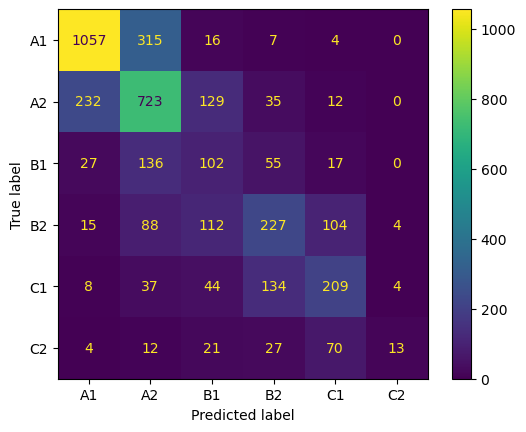

In [42]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [3]:
wandb.finish()

In [4]:
wandb.init(project="wz_experimental", name="confused-river-4", resume=True)
wandb.finish()

wandb: Currently logged in as: kawishbit (kawishbit-org). Use `wandb login --relogin` to force relogin
